# KNN and Tree_based Algorithms 

## `00 ` Import libraries 

In [2]:
import numpy as np
import pandas as pd
# visulaization
import matplotlib.pyplot as plt
import seaborn as sns
#for Normalization
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer
#check normality
from scipy.stats import shapiro
#handling categorical feature
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
#spliting data
from sklearn.model_selection import train_test_split
#evaluating models
from sklearn.metrics import f1_score, classification_report
#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

pd.set_option('display.max_columns', None)


In [10]:
import io
# from google.colab import files
# uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['adult.csv']), na_values= '?')
# df = pd.read_csv('/content/adult.csv', na_values= '?')
df.head(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## `01 ` Split Data 

In [11]:
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(df, test_size = 0.2, random_state = 42)

In [12]:
## separating the categorical features and numerical features
num_cols = list(set(df.select_dtypes(exclude=[object]).columns))
cat_cols = list(df.select_dtypes(include=[object]).columns) 


## `02` EDA

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26048 entries, 5514 to 23654
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26048 non-null  int64 
 1   workclass       24612 non-null  object
 2   fnlwgt          26048 non-null  int64 
 3   education       26048 non-null  object
 4   education.num   26048 non-null  int64 
 5   marital.status  26048 non-null  object
 6   occupation      24606 non-null  object
 7   relationship    26048 non-null  object
 8   race            26048 non-null  object
 9   sex             26048 non-null  object
 10  capital.gain    26048 non-null  int64 
 11  capital.loss    26048 non-null  int64 
 12  hours.per.week  26048 non-null  int64 
 13  native.country  25574 non-null  object
 14  income          26048 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.2+ MB


### `2.1` Check Normality

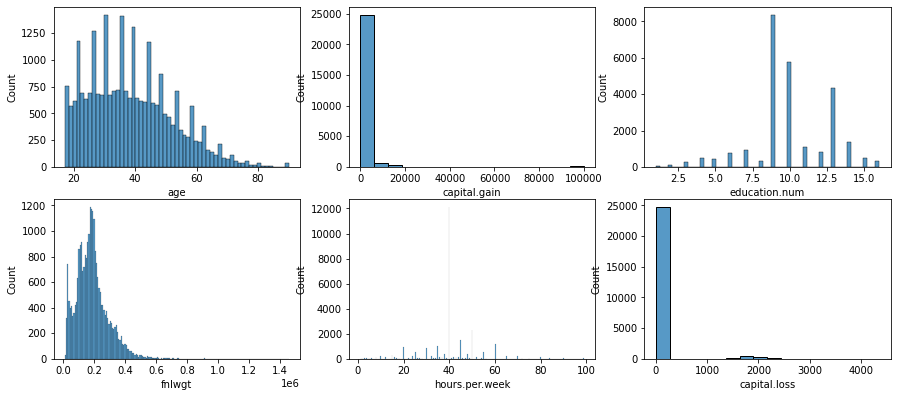

In [14]:
plt.figure(figsize=(15,10))
for i, col in enumerate(train_data[num_cols]):
    ax = plt.subplot(3, 3, i+1)
    sns.histplot(train_data[col], ax=ax)
plt.show()

### `2.2` Check Nulls

In [15]:
nulls_df = ((train_data.isnull().sum()/train_data.shape[0])*100).sort_values(ascending=False).reset_index().rename(columns = { 0 : "Nulls_Count"})
nulls_df[nulls_df['Nulls_Count'] > 0]

,index,Nulls_Count
0,occupation,5.535934
1,workclass,5.512899
2,native.country,1.819717


### `2.3` Check Duplicates

In [16]:
#check Duplicates
df.duplicated().sum()

24

### `2.4` Check Outliers

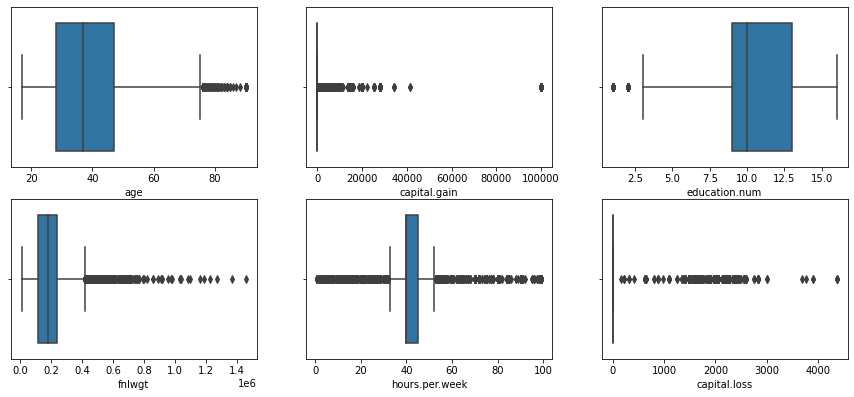

In [17]:
#Check Outliers
plt.figure(figsize=(15,10))
for i, col in enumerate(train_data[num_cols]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x = train_data[col]) 
plt.show()


### `2.5` Check Highly correlated features

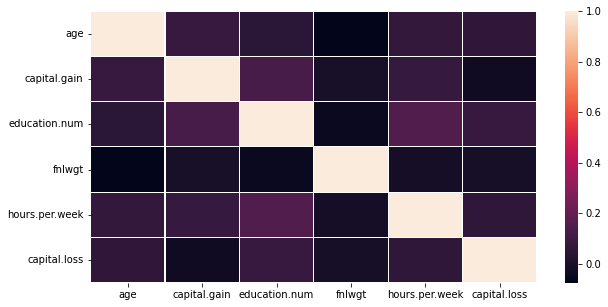

In [18]:
# making a heatmap to inspect the highly correlated features
import seaborn as sns
corr_matrix = train_data[num_cols].corr()
plt.subplots(figsize = (10, 5))
sns.heatmap(corr_matrix, 
           xticklabels = corr_matrix.columns.values,
           yticklabels = corr_matrix.columns.values, 
           linewidth = 0.1)

### `2.6` Check Imbalanced 

In [19]:
train_data['income'].value_counts()

<=50K    19744
>50K      6304
Name: income, dtype: int64

 
> ### **Observations :**
>
> Data have : 
> 1. Nulls
> 2. Duplicate values
> 3. Skewness
> 4. Outliers <br>
> 5. Imbalanced   




## `03` Data Preprocessing

#### `3.1` Handling Nulls

In [20]:
def handling_Nulls (df): 
    df = df.dropna(axis=0, subset=['native.country', 'occupation', 'workclass'])
    df = df.drop(columns = ['fnlwgt'])
    return df

#### `3.2` Handling Outliers

In [21]:
def bounds_calc(train_data, col, boundry_threshold):
  Q1 = np.percentile(train_data[col], q = 25, interpolation = 'midpoint')
  Q3 = np.percentile(train_data[col], q = 75, interpolation = 'midpoint')
  IQR = Q3 - Q1
  Upper_Bound = Q3 + boundry_threshold * IQR
  Lower_Bound = Q1 - boundry_threshold * IQR
  return Lower_Bound, Upper_Bound
    
def outliers_clamping(Lower_Bound, Upper_Bound, value):
  if value > Upper_Bound:
    return Upper_Bound
  elif value < Lower_Bound:
    return Lower_Bound
  else:
    return value

def outliers_handling(train_data, validation_data, boundry_threshold):
    num_data = list(set(train_data.select_dtypes(exclude=[object]).columns) - set(['Id', 'SalePrice']))
    for col in num_data:
        Lower_Bound, Upper_Bound = bounds_calc(train_data, col, boundry_threshold)
        train_data[col] = train_data[col].apply(lambda x : outliers_clamping(Lower_Bound, Upper_Bound, x))
        validation_data[col] = validation_data[col].apply(lambda x : outliers_clamping(Lower_Bound, Upper_Bound, x))
    return train_data, validation_data


#### `3.3` Handling Skewness

In [22]:
def skewness_calc(col ,df):
    std_col = np.std(df[col])
    mean_col = np.mean(df[col])
    size_rows = df.count()[0]
    skewness = np.sum(np.power(df[col] - mean_col, 3))/((size_rows - 1) * np.power(std_col, 3))
    return skewness

def skewed_data_transformation(value):
  return np.log(1 + np.abs(value))

def skewness_handling(train_data, validation_data):
    num_data = list(set(train_data.select_dtypes(exclude=[object]).columns) - set(['Id', 'SalePrice']))
    skewed_train_cols = []
    for col in num_data: 
        sk = skewness_calc(col, train_data)
        if (np.abs(sk) >= 1):
            skewed_train_cols.append(col)
            train_data[col] = train_data[col].apply(lambda x : skewed_data_transformation(x))
            validation_data[col] = validation_data[col].apply(lambda x : skewed_data_transformation(x))
    return train_data, validation_data

#### `3.4` Feature Scaling

##### `3.6.1 ` Shapiro-Wilk(Normal Distribution) test

In [23]:
def Shapiro_Wilk_test (df, num_cols, alpha):
    feats_std_scale = []
    feats_min_max_scale = []
    sample_data  = train_data.sample(replace = False, n= 500)
    for col in num_cols:
        stat, p = shapiro(sample_data[col])
        if p > alpha:
            feats_std_scale.append(col)
        else:
            feats_min_max_scale.append(col)
    return feats_min_max_scale, feats_std_scale

##### `3.6.2 ` Scaling Features

In [24]:
# brute force code , Don't forget to enhance ittttttt  ----------------->
def scaling_features (train_data, validation_data, alpha):
    num_data = list(set(train_data.select_dtypes(exclude=[object]).columns))
    feats_min_max_scale, feats_std_scale = Shapiro_Wilk_test(train_data, num_data, alpha)
    
    if len(feats_std_scale) <= 0  :
        min_max_scaler = MinMaxScaler()
        min_max_scaler_model = min_max_scaler.fit(train_data[feats_min_max_scale])
        min_max_scaled_train_data = pd.DataFrame(min_max_scaler_model.transform(train_data[feats_min_max_scale]), columns = feats_min_max_scale)
        min_max_scaled_validation_data = pd.DataFrame(min_max_scaler_model.transform(validation_data[feats_min_max_scale]), columns = feats_min_max_scale)
        num_train_data = min_max_scaled_train_data
        num_validation_data = min_max_scaled_validation_data
    elif len(feats_min_max_scale) <= 0 :
        std_scaler = StandardScaler()
        std_scaler_model = std_scaler.fit(train_data[feats_std_scale])
        std_scaled_train_data = pd.DataFrame(std_scaler_model.transform(train_data[feats_std_scale]), columns = feats_std_scale)
        std_scaled_validation_data = pd.DataFrame(std_scaler_model.transform(validation_data[feats_std_scale]), columns = feats_std_scale)
        num_train_data = std_scaled_train_data
        num_validation_data = std_scaled_validation_data
    else : 
        min_max_scaler = MinMaxScaler()
        min_max_scaler_model = min_max_scaler.fit(train_data[feats_min_max_scale])
        min_max_scaled_train_data = pd.DataFrame(min_max_scaler_model.transform(train_data[feats_min_max_scale]), columns = feats_min_max_scale)
        min_max_scaled_validation_data = pd.DataFrame(min_max_scaler_model.transform(validation_data[feats_min_max_scale]), columns = feats_min_max_scale)
        
        std_scaler = StandardScaler()
        std_scaler_model = std_scaler.fit(train_data[feats_std_scale])
        std_scaled_train_data = pd.DataFrame(std_scaler_model.transform(train_data[feats_std_scale]), columns = feats_std_scale)
        std_scaled_validation_data = pd.DataFrame(std_scaler_model.transform(validation_data[feats_std_scale]), columns = feats_std_scale)
        
        num_train_data = std_scaled_train_data.merge(min_max_scaled_train_data, right_index = True, left_index = True)
        num_validation_data = std_scaled_validation_data.merge(min_max_scaled_validation_data, right_index = True, left_index = True)
        
    print("features to be scaled with min max",  feats_min_max_scale)
    print("features to be scaled with standarization",  feats_std_scale)
    
    return num_train_data, train_data['income'], num_validation_data, validation_data['income']

#### `3.7` Handling Categorical Data & Merge

In [25]:
nominal_cols = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
ordinal_cols = ['education', 'income']

In [26]:
def handling_catecorical(df, ordinal_cols, nominal_cols):  
    ordinal_train_df = pd.DataFrame()

    for ordinal_feat in ordinal_cols:
        label_enc_model = LabelEncoder().fit(df[ordinal_feat])
        ordinal_train_df[ordinal_feat] = label_enc_model.transform(df[ordinal_feat])
    
    
    one_hot_enc_model = OneHotEncoder(sparse = False).fit(df[nominal_cols])
    nominal_train_data = one_hot_enc_model.transform(df[nominal_cols])

    a=one_hot_enc_model.categories_
    col_names=[]
    for list_ in a:
        for element in list_:
            col_names.append(element)

    nominal_train_df = pd.DataFrame(nominal_train_data, columns = col_names)

    return nominal_train_df, ordinal_train_df


### `3.8` Merge Data

In [27]:
def merge_final_data(nominal_train_df, ordinal_train_df, num_train_df, nominal_test_df, ordinal_test_df, num_validation_df):
    
    final_train_data = nominal_train_df.merge(ordinal_train_df, right_index = True, left_index = True, how = 'inner')\
    .merge(num_train_df, right_index = True, left_index = True, how = 'inner')

    final_test_data = nominal_test_df.merge(ordinal_test_df, right_index = True, left_index = True, how = 'inner')\
    .merge(num_validation_df, right_index = True, left_index = True, how = 'inner')

    return final_train_data, final_test_data

### **Pre-Processing Function** 

In [28]:
def pre_processing(train_data, validation_data, nominal_cols, ordinal_cols, shapiro_alpha):
    
    #0) handling nulls    
    train_data =  handling_Nulls (train_data)
    validation_data =  handling_Nulls (validation_data)

    #1) dropping duplicated Values
    train_data, validation_data =  train_data.drop_duplicates(), validation_data.drop_duplicates()

    #3) Scaling Features
    num_train_data, Y_train, num_validation_data, Y_test = scaling_features (train_data, validation_data, shapiro_alpha)

    #4) handling categorical data     
    nominal_train_df, ordinal_train_df = handling_catecorical(train_data, ordinal_cols, nominal_cols)
    nominal_test_df, ordinal_test_df = handling_catecorical(validation_data, ordinal_cols, nominal_cols)

    #5) Merge all these stuff together
    final_train_data, final_test_data =  merge_final_data(nominal_train_df, ordinal_train_df, num_train_data,
                                                        nominal_test_df, ordinal_test_df, num_validation_data)

    return final_train_data, final_test_data

In [29]:
final_train_data, final_test_data = pre_processing(train_data,
                                                         validation_data,
                                                         nominal_cols,
                                                         ordinal_cols,
                                                         shapiro_alpha = 0.05
                                                        )  
print(f'final_train_data shape = {final_train_data.shape}')  
print(f'final_test_data shape = {final_test_data.shape}')     

features to be scaled with min max ['age', 'capital.gain', 'education.num', 'hours.per.week', 'capital.loss']
features to be scaled with standarization []
final_train_data shape = (21909, 89)
final_test_data shape = (5791, 87)


In [30]:
Y_train = final_train_data[['income']]
X_train = final_train_data.loc[:, final_train_data.columns!='income']

X_test = final_test_data.loc[:, final_test_data.columns!='income']
Y_test = final_test_data[['income']]

common_col = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_col]   
X_test = X_test[common_col]   

print(f'X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}')
print(f'X_test shape : {X_test.shape}, Y_test shape : {Y_test.shape}')

X_train shape : (21909, 86), Y_train shape : (21909, 1)
X_test shape : (5791, 86), Y_test shape : (5791, 1)


#### `3.8` Handling Imbalanced Data

In [31]:
pd.value_counts(Y_train.values.flatten())

0    16309
1     5600
dtype: int64

In [32]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

over = SMOTE(sampling_strategy = {1 : 10600}, k_neighbors=2, random_state=42)
X_train, Y_train = over.fit_resample(X_train ,Y_train)
under = RandomUnderSampler(sampling_strategy = {0:10600}, random_state=42)
X_train, Y_train = under.fit_resample(X_train, Y_train)
pd.value_counts(Y_train.values.flatten())

0    10600
1    10600
dtype: int64

## `05`  Finaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaally Training The Model :D 

## `01` KNN

### `Grid search` 

In [ ]:
n_neighbors = [9, 10, 11, 12]
p = [1, 2]   # For manhattan and euclidean distance
weights = ['uniform', 'distance']
random_grid = {'n_neighbors': n_neighbors,
               'p': p,
               'weights': weights}
scorer = make_scorer(f1_score)
knn_clf = KNeighborsClassifier(n_jobs=-1)

In [ ]:
grid_search = GridSearchCV(estimator = knn_clf, 
                           param_grid = random_grid, 
                           scoring = scorer, 
                           cv = 3, 
                           verbose = 1).fit(X_train.values, Y_train.values.ravel())
grid_search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', p=1, n_jobs=-1)
knn.fit(X_train, Y_train.values.ravel())
knn_y_pred = knn.predict(X_test)

print("Train : ", classification_report(Y_train, knn.predict(X_train)))
print("Test : ", classification_report(Y_test, knn_y_pred))

Train :                precision    recall  f1-score   support

           0       0.97      1.00      0.99     10600
           1       1.00      0.97      0.99     10600

    accuracy                           0.99     21200
   macro avg       0.99      0.99      0.99     21200
weighted avg       0.99      0.99      0.99     21200

Test :                precision    recall  f1-score   support

           0       0.90      0.79      0.84      4357
           1       0.54      0.73      0.62      1434

    accuracy                           0.78      5791
   macro avg       0.72      0.76      0.73      5791
weighted avg       0.81      0.78      0.79      5791



## `02` Decision Tree

### ` Grid search `

In [65]:
min_samples_split = [10, 20]
max_features = [3, 5, 10, 15]
max_depth = [5, 10, 15, 20, 25, 30]
min_samples_leaf = [10, 20]
max_leaf_nodes = [5, 10]
ccp_alpha = [int(x) for x in np.linspace(0.001, 0.01, num = 5)]
random_grid = {'min_samples_split': min_samples_split,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,
               'ccp_alpha': ccp_alpha}

scorer = make_scorer(f1_score)
tree_clf = DecisionTreeClassifier(random_state = 2022)

In [66]:
grid_search = GridSearchCV(estimator = tree_clf, 
                           param_grid = random_grid, 
                           scoring = scorer, 
                           cv = 3).fit(X_train, Y_train.values.flatten())
grid_search.best_params_

{'ccp_alpha': 0,
 'max_depth': 10,
 'max_features': 10,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 10}

In [75]:
tree_clf = DecisionTreeClassifier(ccp_alpha=0,
                                  max_depth=10,
                                  max_features=10,
                                  max_leaf_nodes = 10,
                                  min_samples_leaf = 10,
                                  min_samples_split = 10,
                                  random_state = 2022)

tree_clf.fit(X_train, Y_train)
tree_y_pred = tree_clf.predict(X_test)

print("Train : ", classification_report(Y_train, tree_clf.predict(X_train)))
print("Test : ", classification_report(Y_test, tree_y_pred))


Train :                precision    recall  f1-score   support

           0       0.84      0.72      0.78     10600
           1       0.76      0.86      0.80     10600

    accuracy                           0.79     21200
   macro avg       0.80      0.79      0.79     21200
weighted avg       0.80      0.79      0.79     21200

Test :                precision    recall  f1-score   support

           0       0.93      0.72      0.81      4357
           1       0.49      0.83      0.62      1434

    accuracy                           0.75      5791
   macro avg       0.71      0.78      0.71      5791
weighted avg       0.82      0.75      0.76      5791



### `DecisionTree plot`

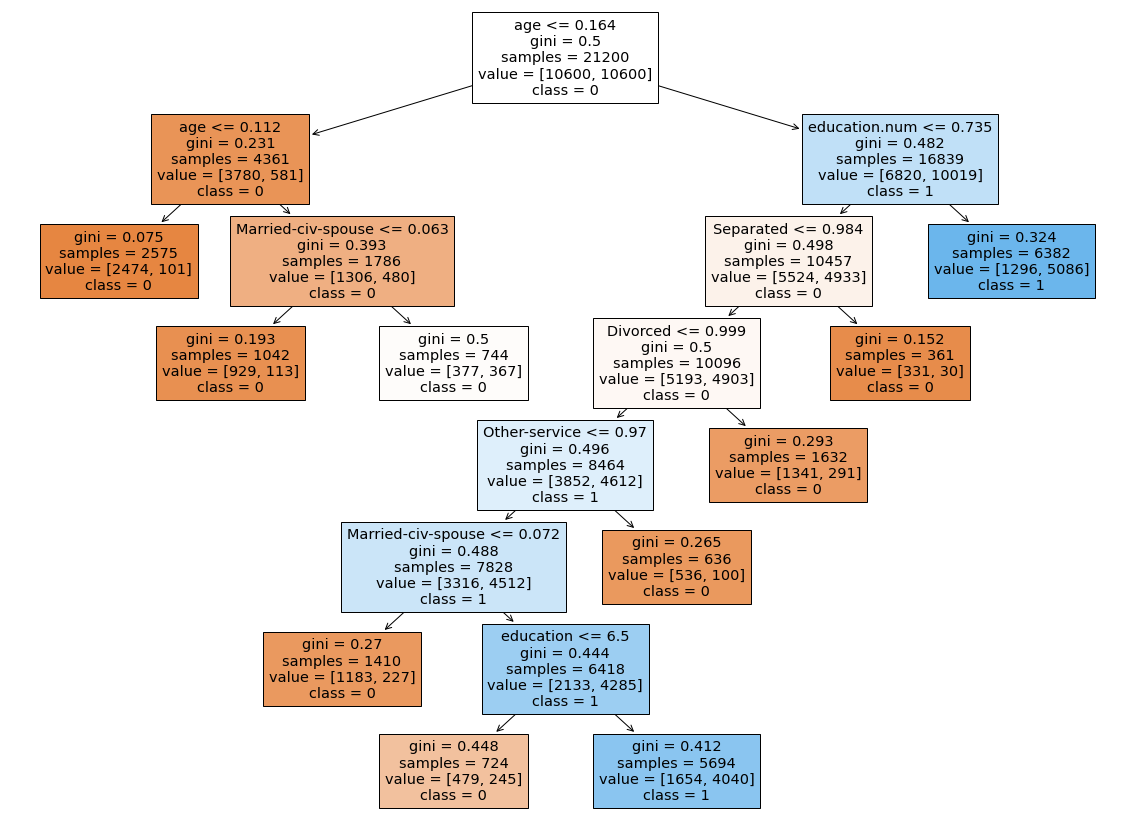

In [76]:
from sklearn import tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(tree_clf, 
                   feature_names=X_train.columns.to_list(),  
                   class_names=['0', '1'],
                   filled=True)

# `Random Forest`

### `Grid search`

In [49]:
n_estimators = [100, 200, 300, 400, 500]
max_features = ['auto', 'sqrt']
max_depth = [20, 25, 30, 35]
max_samples = [1000, 1500, 2000, 2500, 3000]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'max_samples': max_samples}

scorer = make_scorer(f1_score)
rf = RandomForestClassifier(bootstrap=True, random_state = 2022)

In [54]:
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = random_grid, 
                           scoring = scorer, 
                           cv = 3).fit(X_train, Y_train.values.flatten())
grid_search.best_params_

{'max_depth': 25,
 'max_features': 'auto',
 'max_samples': 3000,
 'n_estimators': 300}

In [58]:
rf_clf = RandomForestClassifier(n_estimators=300,
                                max_depth=25,
                                max_features='auto',
                                max_samples=3500,
                                bootstrap=True,
                                random_state = 2022)
rf_clf.fit(X_train, Y_train)
rf_y_pred = rf_clf.predict(X_test)
print("Train : ", classification_report(Y_train, rf_clf.predict(X_train)))
print("Test : ", classification_report(Y_test, rf_y_pred))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Train :                precision    recall  f1-score   support

           0       0.92      0.84      0.88     10600
           1       0.85      0.93      0.89     10600

    accuracy                           0.89     21200
   macro avg       0.89      0.89      0.89     21200
weighted avg       0.89      0.89      0.89     21200

Test :                precision    recall  f1-score   support

           0       0.94      0.81      0.87      4357
           1       0.59      0.85      0.70      1434

    accuracy                           0.82      5791
   macro avg       0.77      0.83      0.78      5791
weighted avg       0.85      0.82      0.83      5791

